# Primerjava pristopov za luščenje ključnih besed na izhodiščnih podatkih SemEval

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz nabora besedil [SemEval](https://www.aclweb.org/anthology/S10-1004/), ki vsebuje 244 polnih člankov o računalništvu s portala ACM, pri čemer ključne besede podajo avtorji člankov.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno preciznost (precision), priklic (recall) in mero F1.

Tokrat med metode za odkrivanje ključnih besed dodamo še eno, ki temelji na vektorskih vložitvah dokumentov in besed. Uporabili bomo metodo iz skupine transformejev in sicer eno različico metode RoBERTa. Skupina metod, ki temelji na transformerjiih trenutno predstavlja najbolj uspešno skupino metod pri različnih aplikacijah na področju obdelave naravnega jezika.

In [1]:
import string
import ast

import nltk
from textsemantics.server_api import ServerAPI
from textsemantics.specific_words import cos_sim
from textsemantics import specific_words
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from matplotlib import pyplot as plt
import yake
from gensim.summarization import keywords as gensim_kw
import rake
from sentence_transformers import SentenceTransformer
import numpy as np

from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)

Naložimo metapodatke in dokumente iz zbirke _semeval_ - računalniški članki iz referenčne podatkovne zbirke SemEval. Dokumente preprocesiramo in izluščimo posamezne besede.

In [2]:
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords', quiet=True)
# lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
snow_stemmer = SnowballStemmer(language='english') 

def preprocess(corpus):
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [snow_stemmer.stem(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('semeval')
# stolpec s ključnimi besedami vsebuje seznam zapisan kot niz - pretvori v seznam
metadata["Keywords"] = metadata["Keywords"].apply(ast.literal_eval)
# ne lematiziramo, ker so izhodiščne besede že korenjene (Porter Stemmer)
metadata["Keywords_one_word"] = metadata["Keywords"].apply(
    lambda ph: [w.strip('][ )') for p in ph for w in p.split()]
)
# izpusti članke brez ključnih besed
metadata = metadata[metadata["Keywords_one_word"].str.len() != 0]

tokens_list = preprocess(metadata["Content"])

print(f"Število dokumentov: {len(metadata)}")

Število dokumentov: 100


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [3]:
metadata.head()

,Content,File,Keywords,Keywords_one_word
0,Realistic Cognitive Load Modeling for Enhancin...,http://file.biolab.si/text-semantics/data/seme...,"[cognit model, human-center teamwork, share be...","[cognit, model, human-center, teamwork, share,..."
1,Design and Implementation of a Distributed Con...,http://file.biolab.si/text-semantics/data/seme...,"[distribut content manag, continu media storag]","[distribut, content, manag, continu, media, st..."
2,Edge Indexing in a Grid for Highly Dynamic Vir...,http://file.biolab.si/text-semantics/data/seme...,"[3d object stream, object pop problem, spatial...","[3d, object, stream, object, pop, problem, spa..."
3,Interactions between Market Barriers and Commu...,http://file.biolab.si/text-semantics/data/seme...,"[social network, cognit model, artifici social...","[social, network, cognit, model, artifici, soc..."
4,Distributed Norm Management in Regulated Multi...,http://file.biolab.si/text-semantics/data/seme...,"[regul multi-agent system, norm conflict, elec...","[regul, multi-agent, system, norm, conflict, e..."


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metoda z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [4]:
%%time 
tfidf_keywords = specific_words.tfidf_keywords(None, tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

CPU times: user 2.56 s, sys: 14.8 ms, total: 2.57 s
Wall time: 2.58 s


In [5]:
%%time 
emb_doc_keywords = specific_words.embedding_document_keywords(None, tokens_list)
emb_doc_keywords = [[x for x, _ in wds] for wds in emb_doc_keywords]

CPU times: user 19.8 s, sys: 933 ms, total: 20.7 s
Wall time: 20.8 s


In [6]:
# izhodiščne besede so korenjene s Porter Stemmer
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [7]:
%%time 
stop_path = "utils/english-stopwords.txt"
rake_object = rake.Rake(stop_path, max_words_length=1)
def rake_method(text):    
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [stemmer.stem(x) for x, _ in kw]

rake_keywords = [rake_method(txt) for txt in metadata["Content"]]

CPU times: user 7.81 s, sys: 2.49 ms, total: 7.82 s
Wall time: 7.82 s


In [8]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="en", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [stemmer.stem(x) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in metadata["Content"]]

CPU times: user 51.4 s, sys: 1.38 s, total: 52.7 s
Wall time: 53 s


In [9]:
%%time
def text_rank(tokens):
    kw = gensim_kw(" ".join(tokens), words=20, scores=True)
    return [x for w, _ in kw for x in w.split()]

text_rank_keywords = [text_rank(tokens) for tokens in tokens_list]

CPU times: user 1min 43s, sys: 21 s, total: 2min 4s
Wall time: 1min 49s


In [10]:
%%time

def transformer(text_list):
    return [keywords_transformer(text) for text in text_list]

def keywords_transformer(text):
    e = SentenceTransformer('paraphrase-distilroberta-base-v1')
    doc_emb = e.encode(text)
    tokens = np.unique(RegexpTokenizer('\w+').tokenize(text))
    word_embs = e.encode(tokens)
    dists = list()
    words = list()
    for i, token in enumerate(tokens):
        words.append(token)
        dists.append(1 - cos_sim(doc_emb, word_embs[i, :]))

    idx = np.argsort(dists)
    results = list()
    unique_words = list()
    for i in idx:
        if words[i] not in unique_words:
            results.append((words[i], dists[i]))
            unique_words.append(words[i])
    
    return results

transformer_keywords = transformer(list(metadata['Content']))
transformer_keywords = [[x for x, _ in wds] for wds in transformer_keywords]
transformer_keywords = preprocess([" ".join(kws) for kws in transformer_keywords])

CPU times: user 28min 56s, sys: 46.5 s, total: 29min 42s
Wall time: 29min 47s


In [11]:
methods = [
    ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
    ("Transformer", transformer_keywords)
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [12]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

Emb - document - Povprečno število besed: 875.2 Minimalno število specifičnih besed: 561
TFIDF - Povprečno število besed: 875.2 Minimalno število specifičnih besed: 561
RAKE - Povprečno število besed: 622.3 Minimalno število specifičnih besed: 379
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 20
TextRank - Povprečno število besed: 20.9 Minimalno število specifičnih besed: 20
Transformer - Povprečno število besed: 1211.9 Minimalno število specifičnih besed: 730


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [13]:
kw = metadata['Keywords_one_word']
precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

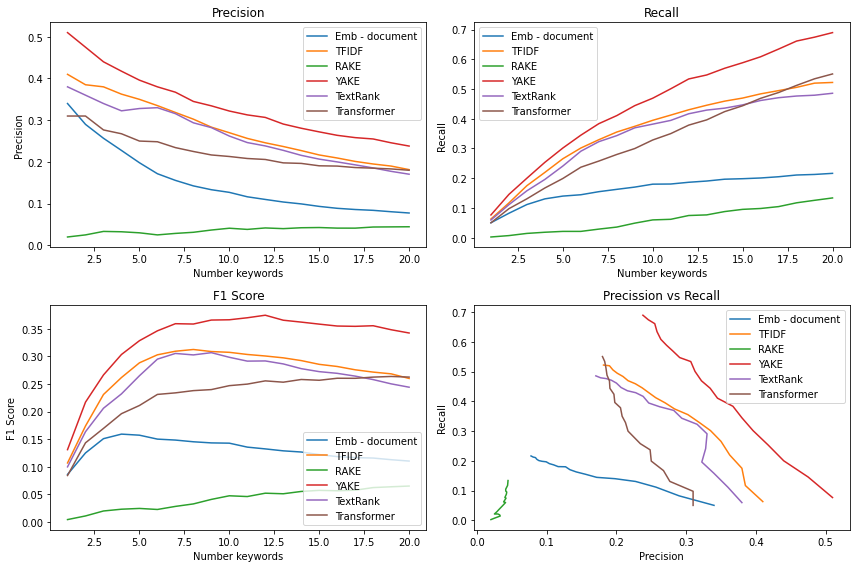

In [14]:
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
for i, (title, sc) in enumerate(scores):
    plt.subplot(2, 2, i + 1)
    for p, (l, _) in zip(sc, methods):
        plt.plot(range(1, 21), p, label=l)
    plt.legend()
    plt.title(title)
    plt.xlabel("Number keywords")
    plt.ylabel(title)
        
plt.subplot(2, 2, 4)
for p, r, (l, _) in zip(precisions, recalls, methods):
    plt.plot(p, r, label=l)
    plt.legend()
    plt.title("Precission vs Recall")
    plt.xlabel("Precision")
    plt.ylabel("Recall")

plt.tight_layout()

Iz grafov lahko sklepamo, da se na primeru člankov podatkovne zbirke SemEval najbolje obnese metoda YAKE!. Sledita TF-IDF in Text Rank. Razlika med YAKE in TF-IDF je na tem korpusu večja kot pri korpusu Schutz2008. Transformer deluje boljše kot fastText, vendar pa ne boljše kot YAKE, TextRank in TF-IDF. Ko bolj podrobno pogledamo, lahko vidimo, da so besede, ki jih odkrijeta metodi na podlagi vektorskih vložitev take, da opisujejo bolj širše področje, na katero se dokument nanaša, kar je v določenih primerih zaželeno. 